# Import packages

In [88]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Load embeddings

In [89]:
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

def extract_model_nickname(file_name):
    return file_name[6:-5]

def extract_model_name_from_nickname(model_nickname):
    return '_'.join(model_nickname.split('_')[:-1])

In [90]:
basemodel_nickname = 'vgg19_pretrained'
topk_s=20
dim=30
lr_emb=0.05
num_emb_epochs=10000
num_emb_negs=3
lr_img_emb=10.0
thr_img_emb=0.001
max_iter_img_emb=10000
k=10

apdx1 = f'topk_s={topk_s}-dim={dim}-lr_emb={lr_emb}-num_emb_epochs={num_emb_epochs}-num_emb_negs={num_emb_negs}'
apdx2 = f'dim=30-lr_img_emb={lr_img_emb}-thr_img_emb={thr_img_emb}-max_iter_img_emb={max_iter_img_emb}-k={k}'
dir_path = f'../../../data/embedding/emb-{basemodel_nickname}-{apdx1}/data/emb-set-{apdx2}/emb_2d'
fig_dir = os.path.join(dir_path, 'fig')
file_names = sorted(os.listdir(dir_path))
file_names = [f for f in file_names if f.endswith('.json')]

file_names

['emb2d-convnext_0.004_0.json',
 'emb2d-convnext_0.004_1.json',
 'emb2d-convnext_0.004_3.json',
 'emb2d-convnext_0.004_91.json',
 'emb2d-convnext_0.004_96.json',
 'emb2d-convnext_0.004_lambda0_0.json',
 'emb2d-convnext_0.004_lambda0_1.json',
 'emb2d-convnext_0.004_lambda0_2.json',
 'emb2d-convnext_0.004_lambda0_32.json',
 'emb2d-convnext_0.004_lambda0_7.json',
 'emb2d-convnext_0.02_0.json',
 'emb2d-convnext_0.02_10.json',
 'emb2d-convnext_0.02_11.json',
 'emb2d-convnext_0.02_12.json',
 'emb2d-convnext_0.02_13.json',
 'emb2d-convnext_0.02_14.json',
 'emb2d-convnext_0.02_15.json',
 'emb2d-convnext_0.02_17.json',
 'emb2d-convnext_0.02_19.json',
 'emb2d-convnext_0.02_3.json',
 'emb2d-convnext_0.02_6.json',
 'emb2d-convnext_0.02_8.json',
 'emb2d-convnext_0.02_9.json',
 'emb2d-vgg19_pretrained.json']

In [91]:
emb2d = {}
for file_name in file_names:
    file_path = os.path.join(dir_path, file_name) 
    data = load_json(file_path)
    
    model_nickname = extract_model_nickname(file_name)
    emb2d[model_nickname] = data

In [92]:
model_nicknames = list(emb2d.keys())
# model_nicknames = [
#     'vgg19_pretrained',
#     'convnext_0.004_0',
#     'convnext_0.004_1',
#     'convnext_0.004_3',
#     'convnext_0.004_91',
#     'convnext_0.004_96', 
#     'convnext_0.004_lambda0_0',
#     'convnext_0.004_lambda0_1',
#     'convnext_0.004_lambda0_2',
#     'convnext_0.004_lambda0_7',
#     'convnext_0.004_lambda0_32',
#     'convnext_0.02_0',
#     'convnext_0.02_3',
#     'convnext_0.02_6',
#     'convnext_0.02_8',
#     'convnext_0.02_9',
#     'convnext_0.02_10',
#     'convnext_0.02_11',
#     'convnext_0.02_12',
#     'convnext_0.02_13',
#     'convnext_0.02_14',
#     'convnext_0.02_15',
#     'convnext_0.02_17',
#     'convnext_0.02_19',
#     'inception_v3_1.5_0',
#     'inception_v3_1.5_4',
#     'inception_v3_1.5_70',
#     'inception_v3_1.5_71',
#     'inception_v3_1.5_72',
#     'inception_v3_1.5_73',
#     'inception_v3_1.5_100',
#     'vgg16_0.01_0',
#     'vgg16_0.01_5',
#     'vgg16_0.01_7',
#     'vgg16_0.01_21',
#     'vgg16_0.01_207',
#     'vgg16_0.05_0',
#     'vgg16_0.05_3',
#     'vgg16_0.05_12',
#     'vgg16_0.05_13',
#     'vgg16_0.05_14',
#     'vgg16_0.05_54',
#     'vgg16_no_dropout_0.01_0',
#     'vgg16_no_dropout_0.01_1',
#     'vgg16_no_dropout_0.01_3',
#     'vgg16_no_dropout_0.01_30',
# ]   

In [93]:
# model_nicknames = list(emb2d.keys())
# model_nicknames = sorted(model_nicknames)
model_names = []
for model_nickname in model_nicknames:
    if basemodel_nickname in model_nickname:
        model_name = basemodel_nickname
    else:
        model_name = extract_model_name_from_nickname(model_nickname)
    if model_name not in model_names:
        model_names.append(model_name)

model_names

['convnext_0.004',
 'convnext_0.004_lambda0',
 'convnext_0.02',
 'vgg19_pretrained']

# Get the range of coordinates

In [94]:
X_range, Y_range = [1000, -1000], [1000, -1000]
for model_nickname in model_nicknames:
    for neuron in emb2d[model_nickname]:
        x, y = emb2d[model_nickname][neuron]
        X_range[0] = min(X_range[0], x)
        X_range[1] = max(X_range[1], x)
        Y_range[0] = min(Y_range[0], y)
        Y_range[1] = max(Y_range[1], y)
        
X_range[0] -= 0.1
X_range[1] += 0.1
Y_range[0] -= 0.1
Y_range[1] += 0.1

print('X_range:', X_range)
print('Y_range:', Y_range)

X_range: [0.8929112195968628, 12.837658500671386]
Y_range: [3.5511788368225097, 12.120565032958984]


# Get 2D embedding visualization

In [95]:
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']
color_map = {
    'vgg19': colors[1],
    'vgg16_0.01': colors[2],
    'vgg16_0.05': colors[7],
    'vgg16_no_dropout_0.01': colors[4],
    'inception_v3_1.5': colors[0],
    'convnext_0.004': colors[3],
    'convnext_0.004_lambda0': colors[5],
    'convnext_0.02': colors[6]
}

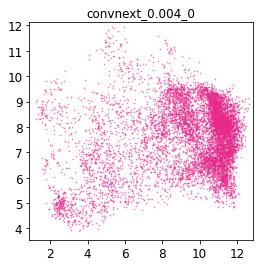

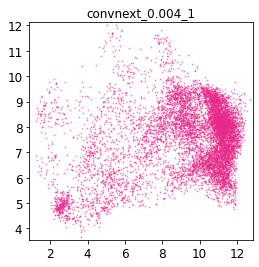

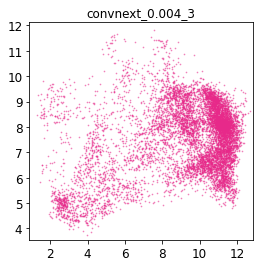

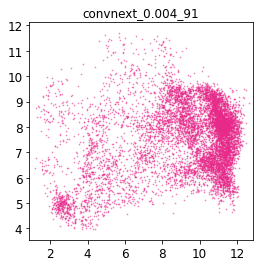

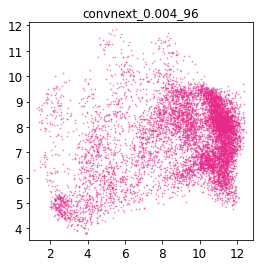

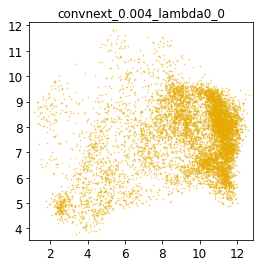

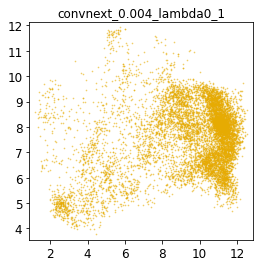

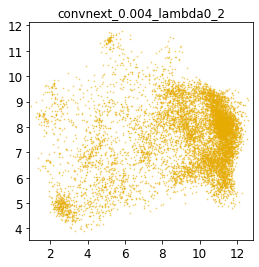

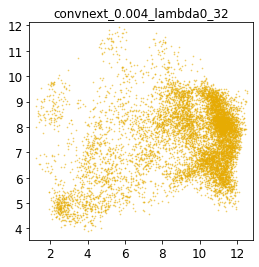

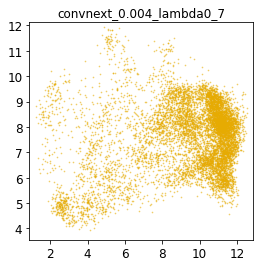

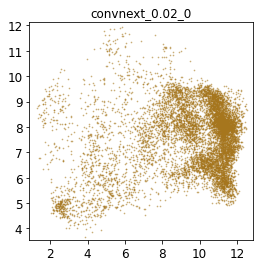

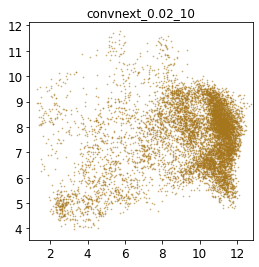

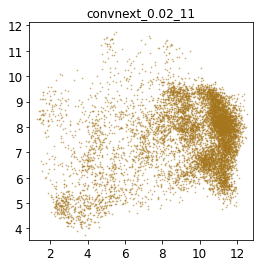

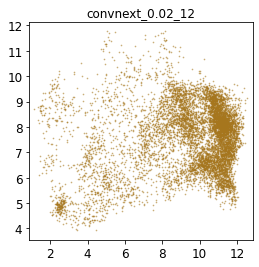

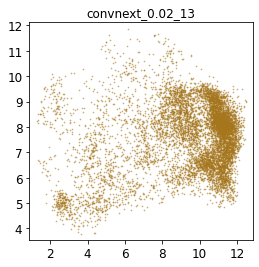

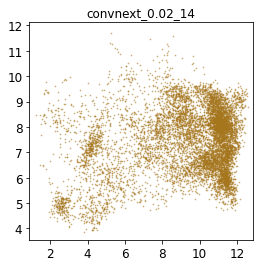

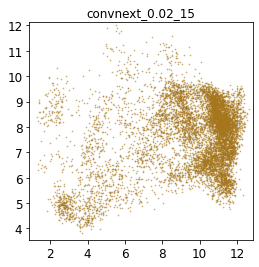

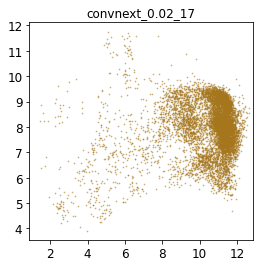

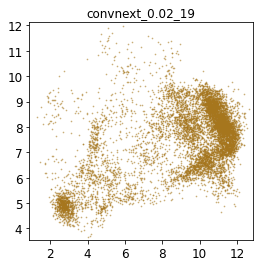

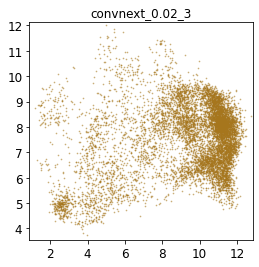

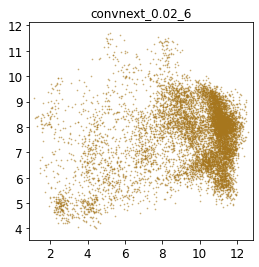

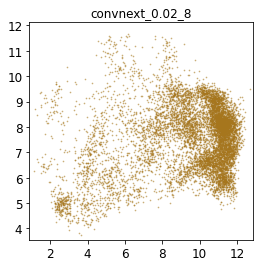

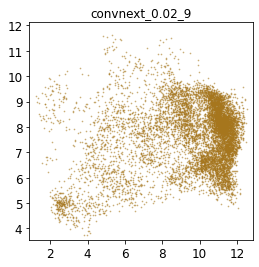

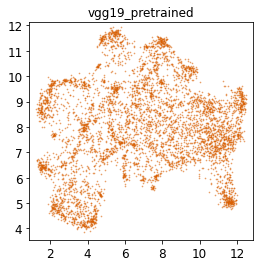

In [96]:
for model_nickname in model_nicknames:
    Xs = [emb2d[model_nickname][neuron][0] for neuron in emb2d[model_nickname]]
    Ys = [emb2d[model_nickname][neuron][1] for neuron in emb2d[model_nickname]]
    
    model_name = extract_model_name_from_nickname(model_nickname)
    color = color_map[model_name]
    
    plt.figure(figsize=(4, 4))
    plt.scatter(Xs, Ys, s=0.5, alpha=0.5, c=color)
    plt.xlim(X_range)
    plt.ylim(Y_range)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(model_nickname)
    # plt.savefig(f'{fig_dir}/{model_nickname}.png')
    # plt.savefig(f'{fig_dir}/{model_nickname}.svg')
    plt.show()

## Find neurons in ConvNeXt that are embedded in a specific region in the embedding space

In [30]:
raw_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

raw_training_datasets = datasets.ImageFolder(
    '../../../../ILSVRC2012/train',
    raw_data_transform
)

def show_imgs(img_idxs):
    for img_idx in img_idxs:
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        plt.title(f'img: {img_idx}')
        plt.imshow(img)
        plt.show()
        
def show_np_imgs_2_rows(imgs, title=None, subplot_titles=None):
    # Create figure
    nrows = 2
    ncols = len(imgs) // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    # Create subplots
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = int(i / ncols)
        col = i - row * ncols
        ax[row, col].imshow(img) 
        ax[row, col].set_axis_off()
        if subplot_titles is not None:
            ax[row, col].set_title(subplot_titles[i])

    # Title
    if title is not None:
        fig.suptitle(title, y=1.06)
        
    # Show the final plot
    plt.show()
        
def show_imgs_2_rows(img_idxs, title=None):
    # Images
    imgs = []
    subplot_titles = []
    for i, img_idx in enumerate(img_idxs):
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        imgs.append(img)
        subplot_titles.append(f'{i}-th img: {img_idx}')
        
    # Show images
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=subplot_titles)
    
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

def get_stimulus_path(model_nickname, topk_s):
    return f'/raid/NeuEvo/data/stimulus/{model_nickname}/data/stimulus-topk_s={topk_s}.json'

def load_stimulus(model_nickname, topk_s):
    p = get_stimulus_path(model_nickname, topk_s)
    data = load_json(p)
    return data

def get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio):
    root = '/raid/NeuEvo/data/neuron_feature'
    return f'{root}/{model_nickname}/data/topk_s={topk_s}-ex_patch_size_ratio={ex_patch_size_ratio}'

def get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    d = get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio)
    paths = []
    for i in range(topk_s):
        paths.append(f'{d}/{layer}-{neuron_idx}-{i}.jpg')
    return paths

def load_img_from_path(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
                     
def show_ex_patch(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    img_ps = get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx)
    imgs = [load_img_from_path(img_path) for img_path in img_ps]
    title = f'{model_nickname}, {layer}-{neuron_idx}'
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=None)

In [57]:
model_nickname = 'convnext_0.004_96'
Xs = [emb2d[model_nickname][neuron][0] for neuron in emb2d[model_nickname]]
Ys = [emb2d[model_nickname][neuron][1] for neuron in emb2d[model_nickname]]
neurons = list(emb2d[model_nickname].keys())

In [58]:
target_neurons = []
for i, (x, y) in enumerate(zip(Xs, Ys)):
    if (10 <= x and x <= 12) and (8 <= y and y <= 9):
        target_neurons.append(neurons[i])
        
target_neurons = target_neurons[-726:-722]

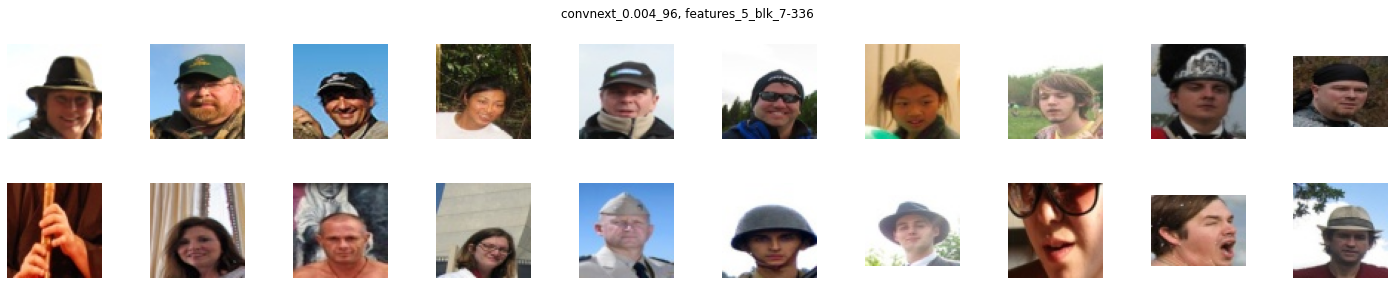

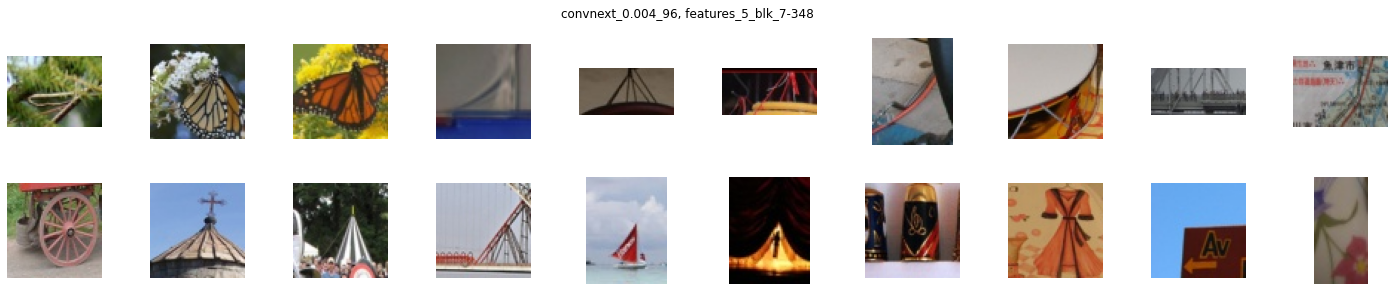

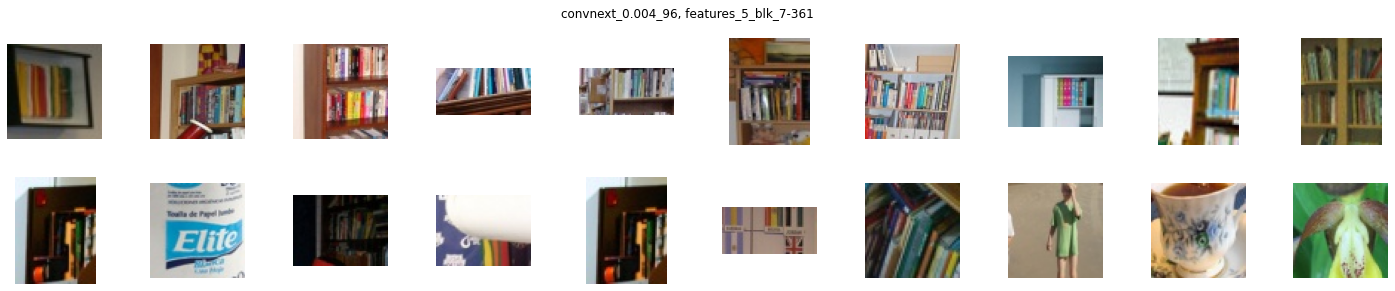

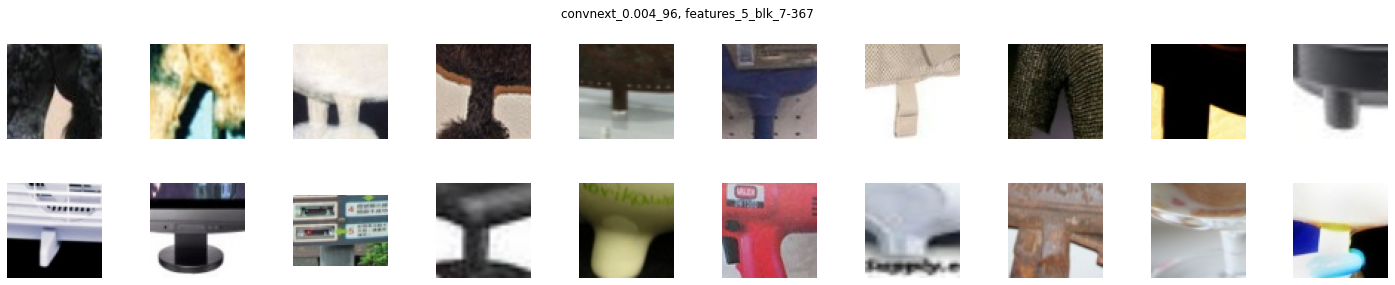

In [59]:
topk_s = 20
ex_patch_size_ratio = 0.3
stimulus = load_stimulus(model_nickname, topk_s)
for neuron in target_neurons:
    layer, n = neuron.split('-')
    n = int(n)
    stimulating_imgs = stimulus[layer][n]
    show_ex_patch(model_nickname, topk_s, ex_patch_size_ratio, layer, n)

In [68]:
target_neurons = []
for i, (x, y) in enumerate(zip(Xs, Ys)):
    if (2 <= x and x <= 4) and (4 <= y and y <= 5):
        target_neurons.append(neurons[i])
        
len(target_neurons)

234

In [75]:
neurons_to_visualize = target_neurons[-120: -115]

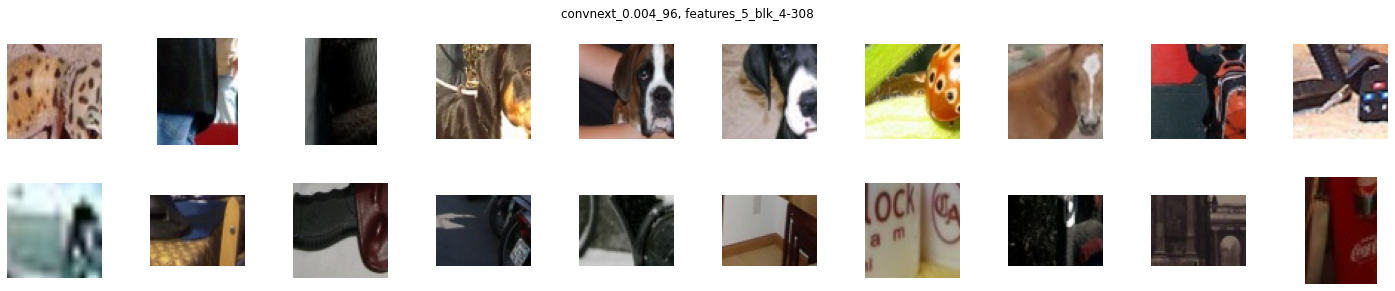

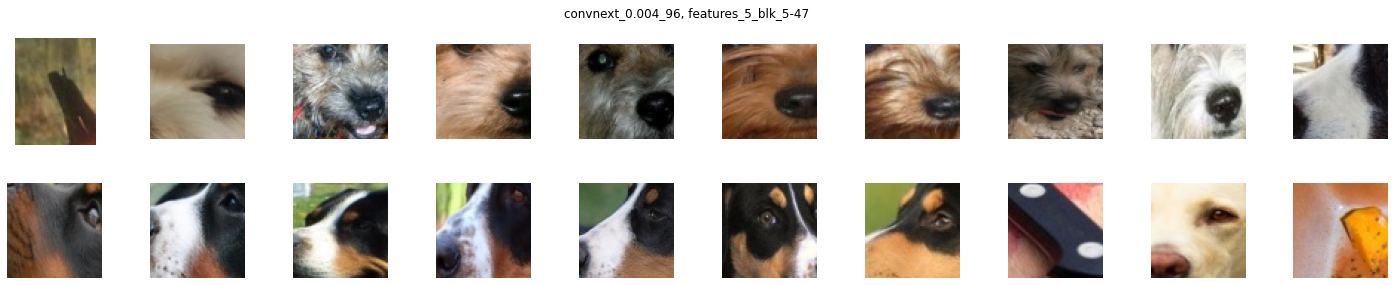

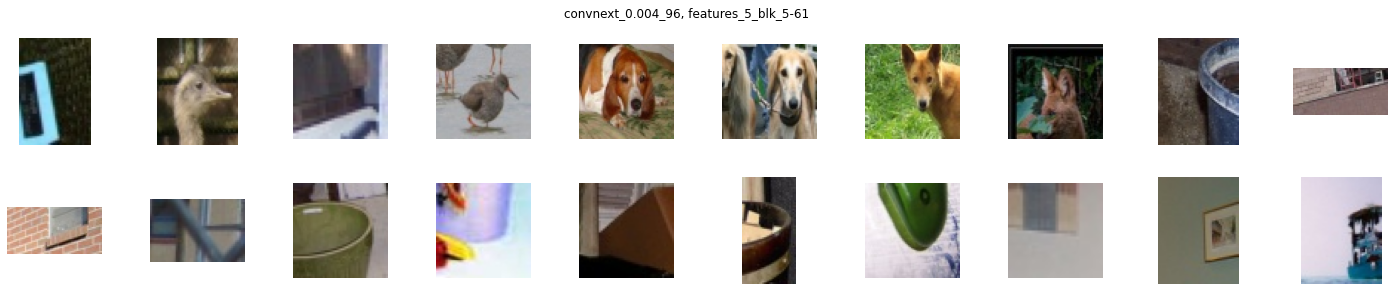

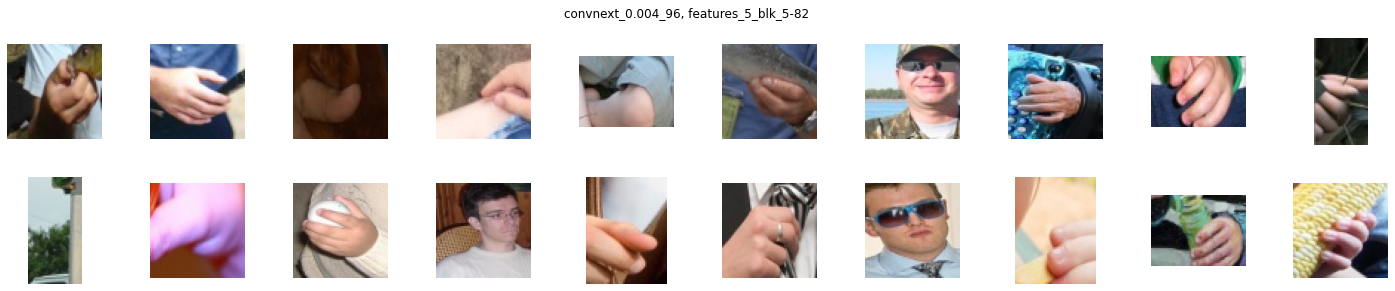

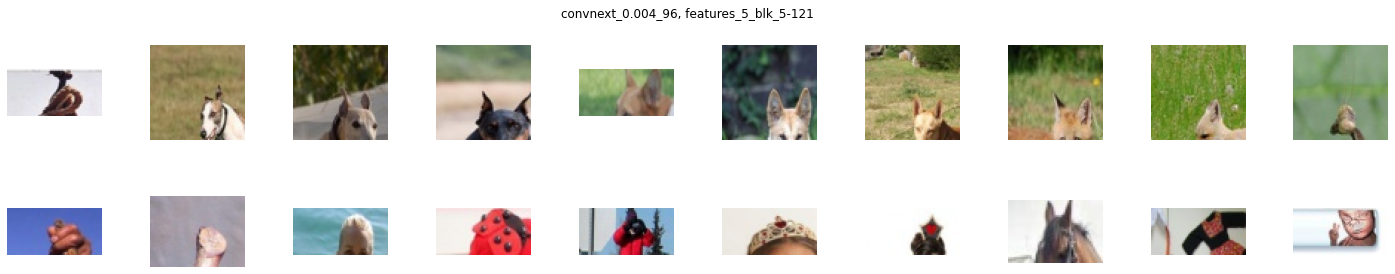

In [76]:
topk_s = 20
ex_patch_size_ratio = 0.3
stimulus = load_stimulus(model_nickname, topk_s)
for neuron in neurons_to_visualize:
    layer, n = neuron.split('-')
    n = int(n)
    stimulating_imgs = stimulus[layer][n]
    show_ex_patch(model_nickname, topk_s, ex_patch_size_ratio, layer, n)

In [78]:
model_nickname = 'vgg19_pretrained'
Xs = [emb2d[model_nickname][neuron][0] for neuron in emb2d[model_nickname]]
Ys = [emb2d[model_nickname][neuron][1] for neuron in emb2d[model_nickname]]
neurons = list(emb2d[model_nickname].keys())

In [79]:
target_neurons = []
for i, (x, y) in enumerate(zip(Xs, Ys)):
    if (2 <= x and x <= 4) and (4 <= y and y <= 5):
        target_neurons.append(neurons[i])
        
# target_neurons = target_neurons[-726:-722]
len(target_neurons)

260

In [85]:
neurons_to_visualize = target_neurons[: 10]

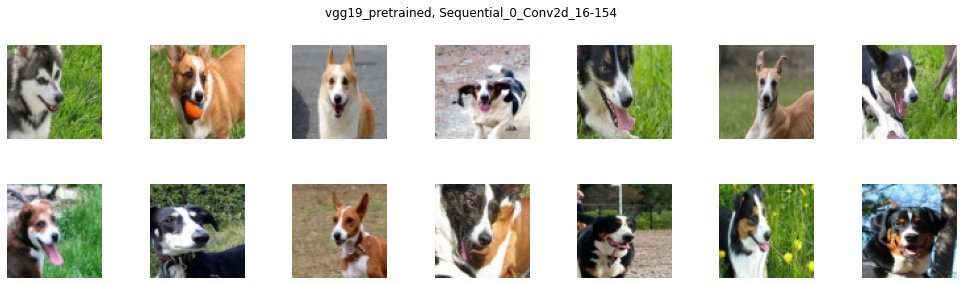

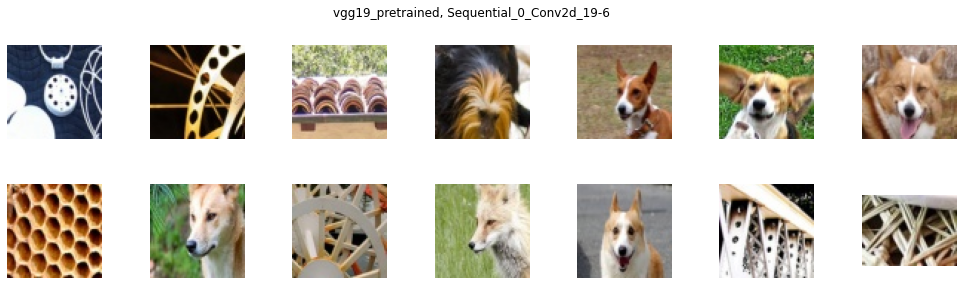

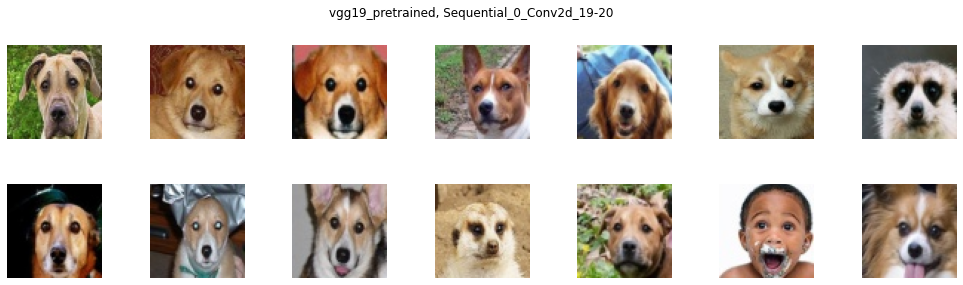

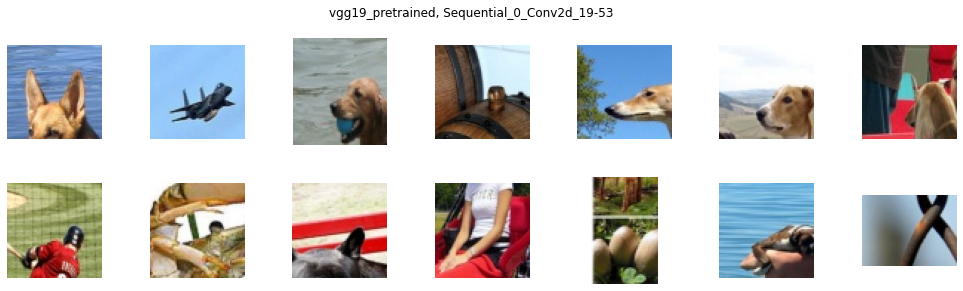

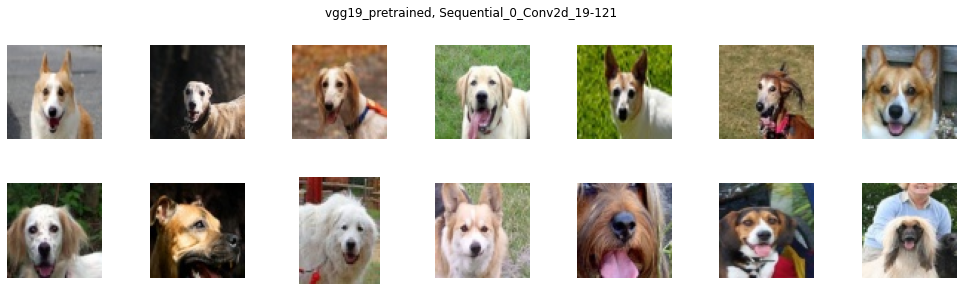

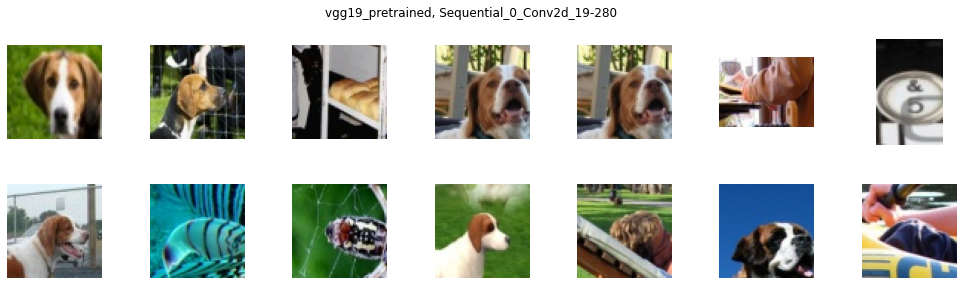

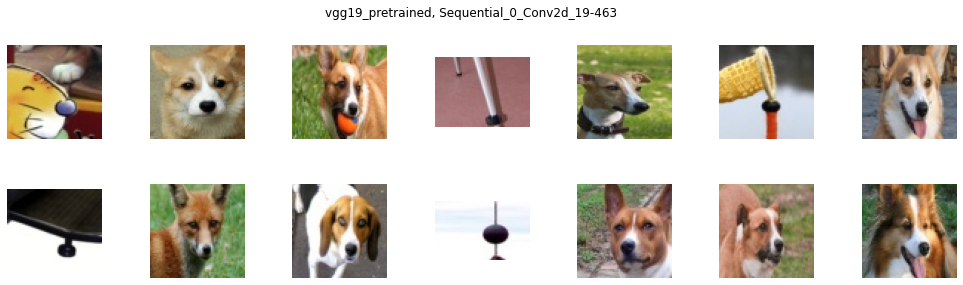

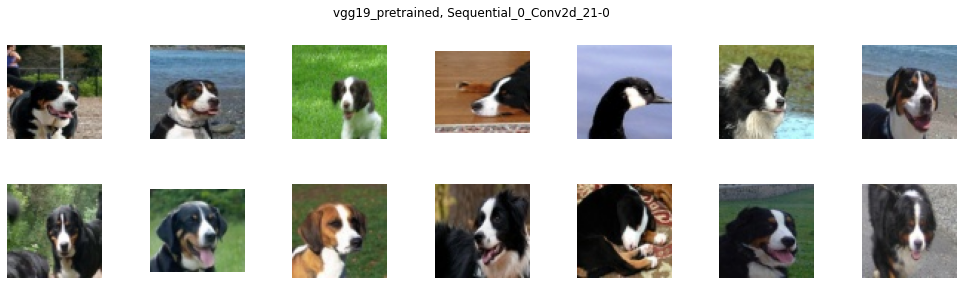

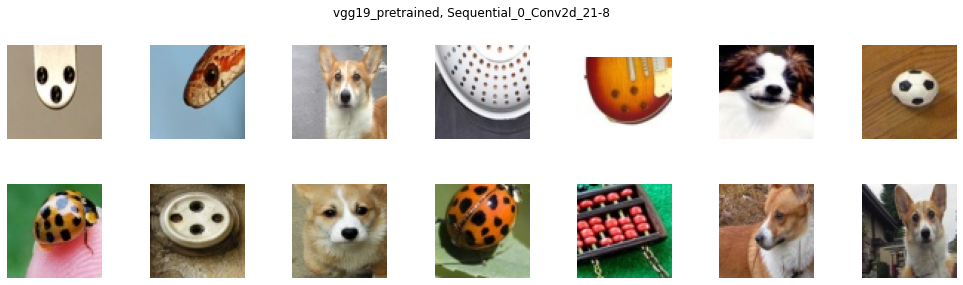

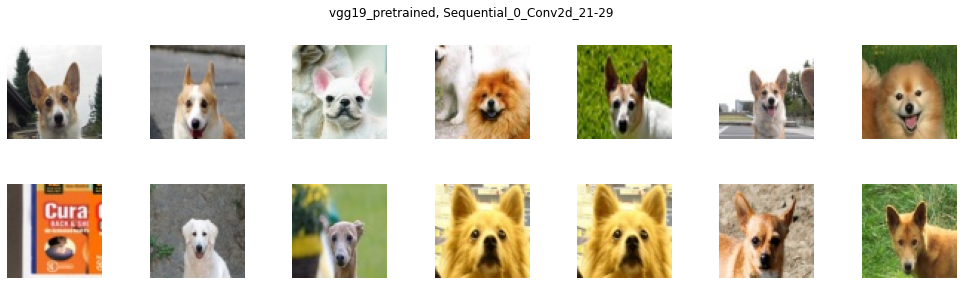

In [87]:
topk_s = 20
ex_patch_size_ratio = 0.3
stimulus = load_stimulus(model_nickname, topk_s)
for neuron in neurons_to_visualize:
    layer, n = neuron.split('-')
    n = int(n)
    stimulating_imgs = stimulus[layer][n]
    show_ex_patch(model_nickname, 15, ex_patch_size_ratio, layer, n)

# Test the quality of image imbedding

In [50]:
import umap
import numpy as np

## Embedding of the base model

In [10]:
base_emb_path = '/raid/NeuEvo/data/embedding/emb-vgg19_pretrained-topk_s=20-dim=30-lr_emb=0.01-num_emb_epochs=100-num_emb_negs=3/data/emb/emb.json'

In [11]:
base_emb = load_json(base_emb_path)
X = np.zeros((len(base_emb), 30))
for neuron_i, neuron in enumerate(base_emb):
    X[neuron_i] = base_emb[neuron]

In [12]:
reducer = umap.UMAP(n_components=2)
reducer = reducer.fit(X)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
base_emb2d = reducer.embedding_

In [14]:
base_emb2d2 = reducer.transform(X)

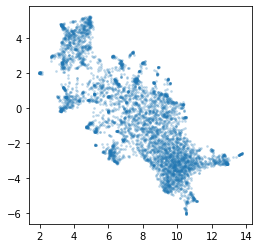

In [15]:
Xs = base_emb2d[:,0]
Ys = base_emb2d[:,1]

plt.figure(figsize=(4, 4))
plt.scatter(Xs, Ys, s=3, alpha=0.2)
plt.show()

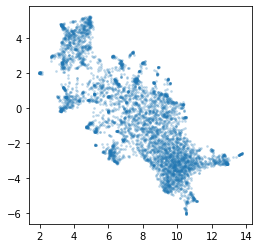

In [16]:
Xs = base_emb2d2[:,0]
Ys = base_emb2d2[:,1]

plt.figure(figsize=(4, 4))
plt.scatter(Xs, Ys, s=3, alpha=0.2)
plt.show()

## Approximated embedding of the base model

In [17]:
img_emb_path = '/raid/NeuEvo/data/embedding/emb-vgg19_pretrained-topk_s=20-dim=30-lr_emb=0.01-num_emb_epochs=100-num_emb_negs=3/data/emb-set-dim=30-lr_img_emb=10.0-thr_img_emb=0.001-max_iter_img_emb=40000-k=10/emb_nd/img_emb.txt'

In [18]:
img_emb = np.loadtxt(img_emb_path)

In [19]:
stimulus_path = '/raid/NeuEvo/data/stimulus/vgg19_pretrained/data/stimulus-topk_s=20.json'
stimulus_base = load_json(stimulus_path)
k = 10
for layer in stimulus_base:
    for neuron, neuron_imgs in enumerate(stimulus_base[layer]):
        stimulus_base[layer][neuron] = neuron_imgs[:k]

In [20]:
neuron_emb = {}
for layer in stimulus_base:
    num_neurons = len(stimulus_base[layer])
    for i in range(num_neurons):
        neuron = f'{layer}-{i}'
        neuron_emb[neuron] = np.random.rand(30) - 0.5

In [21]:
def get_stimulus_of_neuron(neuron, stimulus, k):
    layer, neuron_idx = neuron.split('-')
    neuron_idx = int(neuron_idx)
    return stimulus[layer][neuron_idx][:k]

def compute_approx_neuron_vec(X_n, img_imb):
        vec_sum = np.zeros(30)
        for x in X_n:
            vec_sum += img_emb[x]
        return vec_sum / len(X_n)
    
for neuron in neuron_emb:
    stimulus_neuron = get_stimulus_of_neuron(neuron, stimulus_base, k)
    v_neuron = compute_approx_neuron_vec(stimulus_neuron, img_emb)
    neuron_emb[neuron] = v_neuron
    break

In [22]:
X2 = np.zeros((len(neuron_emb), 30))
for neuron_i, neuron in enumerate(neuron_emb):
    X2[neuron_i] = neuron_emb[neuron]

In [23]:
emb2d_2 = reducer.transform(X2)

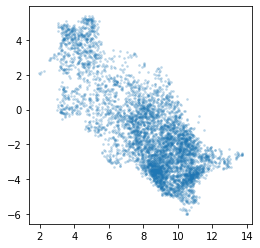

In [24]:
Xs = emb2d_2[:,0]
Ys = emb2d_2[:,1]

plt.figure(figsize=(4, 4))
plt.scatter(Xs, Ys, s=3, alpha=0.2)
plt.show()

## Approximated embedding of VGG16-207